# Imports

In [1]:
import pandas as pd


# import pipeline functions
from recommender_pipeline.data_loader import StandardLoader
from recommender_pipeline.pipelines.general_preprocessing_pipeline import (
    GeneralPreprocessingPipeline,
)
from recommender_pipeline.artist_feature_builder import ArtistFeaturesBuilder

from recommender_pipeline.pipelines.artists_pipeline import ArtistMetadataPipeline
from recommender_pipeline.preprocessors.userwise_minmax_scaler import (
    UserMinMaxListeningScaler,
)
from recommender_pipeline.interaction_matrix_builder import InteractionMatrixBuilder
from recommender_pipeline.models.lightfmbaseline_model import LightFMBaselineModel
from recommender_pipeline.tuner.optuna_tuner import LightFMOptunaOptimizer


# import metrics

from recommender_pipeline.metrics.map_at_k import MAPAtK
from recommender_pipeline.metrics.ndcg_at_k import NDCGAtK
from recommender_pipeline.metrics.precision_at_k import PrecisionAtK
from recommender_pipeline.metrics.recall_at_k import RecallAtK

/Users/macbookpro/Documents/DSDM/Computing for DS/final_project/.venv/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/Users/macbookpro/Documents/DSDM/Computing for DS/final_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Datasets

In [2]:
# user-artist interactions
interactions_df = pd.read_csv('../data/user_artists.dat', sep='\t')


# user-artist dataset about tags
tags_df = pd.read_csv('../data/user_taggedartists.dat', sep='\t')\
    .merge(pd.read_csv('../data/tags.dat', sep='\t', encoding='latin'), on = ['tagID'], how='left')


# adjusted spotify dataset
spotify_df = pd.read_parquet('../data/spotify_unified_artists.parquet')
spotify_df = spotify_df.rename(columns = {'unified_artist_id' : "artistID"})

In [3]:
interactions_df.shape, tags_df.shape, spotify_df.shape

((92834, 3), (186479, 7), (3528311, 19))

In [4]:
interactions_df.columns, tags_df.columns, spotify_df.columns

(Index(['userID', 'artistID', 'weight'], dtype='object'),
 Index(['userID', 'artistID', 'tagID', 'day', 'month', 'year', 'tagValue'], dtype='object'),
 Index(['artist_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
        'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'time_signature', 'track_genre', 'artistID'],
       dtype='object'))

# General Preprocessing

In [5]:
# write how = 'left' if we want to remain each of the spotify artists in the artists' pipeline, otherwise 'inner'
general_pipeline = GeneralPreprocessingPipeline(how='inner')

general_results = general_pipeline.run(interactions_df, tags_df, spotify_df)

In this pipeline features are added to spotify dataset from lastfm dataset, this is important for the following preprocessing and feature engineering tasks, related to the artists' metadata.

In [6]:
general_results['spotify']

,artist_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artistID,artist_tags,num_listeners
0,Tyrone Wells,Days I Will Remember,58.0,214240,0.0,0.688,0.4810,6,-8.807,1,...,0.28900,0.000000,0.1890,0.666,98.017,4,acoustic,17865,the vampire diaries,1
1,Jason Mraz,I'm Yours,80.0,242946,0.0,0.703,0.4440,11,-9.331,1,...,0.55900,0.000000,0.0973,0.712,150.960,4,acoustic,355,21st century girl|4m4zinq|80s|acoustic|acousti...,60
2,Jason Mraz,I Won't Give Up,69.0,240165,0.0,0.483,0.3030,4,-10.058,1,...,0.69400,0.000000,0.1150,0.139,133.406,3,acoustic,355,21st century girl|4m4zinq|80s|acoustic|acousti...,60
3,Landon Pigg,Falling in Love at a Coffee Shop,58.0,244986,0.0,0.489,0.5610,4,-7.933,1,...,0.20000,0.000046,0.1790,0.238,83.457,3,acoustic,16823,indie,1
4,Jason Mraz,I'm Yours,75.0,242946,0.0,0.703,0.4440,11,-9.331,1,...,0.55900,0.000000,0.0973,0.712,150.960,4,acoustic,355,21st century girl|4m4zinq|80s|acoustic|acousti...,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944897,Brian McKnight,Love Is,NaN,286600,NaN,0.501,0.3500,1,-11.253,1,...,0.48600,0.000027,0.1780,0.165,80.042,4,None,11070,brian mcknight|christmas|eargasm|emotional|jaz...,4
944898,Chris de Burgh,The Spirit Of Man,NaN,280426,NaN,0.626,0.7420,7,-15.121,1,...,0.08320,0.022300,0.5200,0.630,120.076,4,None,3876,80s|best christmas songs|british|christmas|hea...,2
944899,Simple Minds,Blindfolded,NaN,323586,NaN,0.568,0.8670,4,-5.381,0,...,0.00068,0.512000,0.5340,0.546,121.995,4,None,993,1979 songs|1980 songs|1981|1981 songs|1982|198...,35
944900,Fito Paez,Cecilia,NaN,248693,NaN,0.261,0.6310,4,-5.192,1,...,0.11300,0.000000,0.4280,0.170,102.263,4,None,5238,fito|latin|oh electropop|rock|rock en espanol|...,5


In [7]:
spotify_new = general_results['spotify']

In [8]:
(spotify_new.isnull().sum() / spotify_new.shape[0]).sort_values(ascending=False)

# share of missing values

explicit            0.972122
popularity          0.620336
track_genre         0.620336
track_name          0.000001
artist_name         0.000000
instrumentalness    0.000000
artist_tags         0.000000
artistID            0.000000
time_signature      0.000000
tempo               0.000000
valence             0.000000
liveness            0.000000
speechiness         0.000000
acousticness        0.000000
mode                0.000000
loudness            0.000000
key                 0.000000
energy              0.000000
danceability        0.000000
duration_ms         0.000000
num_listeners       0.000000
dtype: float64

# Artists Pipeline

In [9]:
# numeric columns to which will be calculated on an artist level

cols_to_use = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'time_signature'
]

In [10]:
artist_pipeline = ArtistMetadataPipeline(numeric_cols=cols_to_use)

In [11]:
spotify_new = artist_pipeline.fit_transform(spotify_new)

HighNullDropper() is done!
PopularityImputer() is done!
GenreTagCombiner() is done!
HighLevelGenreFeatureGenerator() is done!
MostPopularTrackSelector() is done!
PopularityExporter() is done!
ArtistNumericFeatureBuilder(numeric_cols=['danceability', 'energy', 'key',
                                          'loudness', 'mode', 'speechiness',
                                          'acousticness', 'instrumentalness',
                                          'liveness', 'valence', 'tempo',
                                          'time_signature']) is done!
LogMinMaxScaler() is done!


In [12]:
spotify_new.shape

(10410, 24)

In [13]:
spotify_new.isnull().sum().sum()

np.int64(0)

In [14]:
spotify_new.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,genre_hip_hop,genre_classical,genre_metal,mood_happy,mood_sad,mood_chill,mood_energetic,geo_british,geo_latin,geo_asian
artistID,,,,,,,,,,,,,,,,,,,,,
2,0.579918,0.978184,0.909091,0.821571,0.0,0.042560,0.032329,0.047130,0.129032,0.185930,...,0,0,0,0,0,1,0,0,0,0
3,0.158811,0.991576,0.090909,0.817401,1.0,0.142560,0.000219,0.068177,0.337702,0.090251,...,0,0,1,0,0,0,0,0,0,0
5,0.531762,0.998130,0.636364,0.925178,0.0,0.043288,0.107430,0.850957,0.080242,0.236181,...,0,0,0,0,0,0,0,0,0,0
6,0.426230,0.972133,0.818182,0.864146,0.0,0.038085,0.000005,0.168177,0.078125,0.331658,...,0,0,1,0,0,0,0,0,0,0
7,0.636270,0.983200,0.909091,0.792288,0.0,0.057960,0.000782,0.459215,0.061593,0.941709,...,1,0,1,0,1,0,0,0,0,0


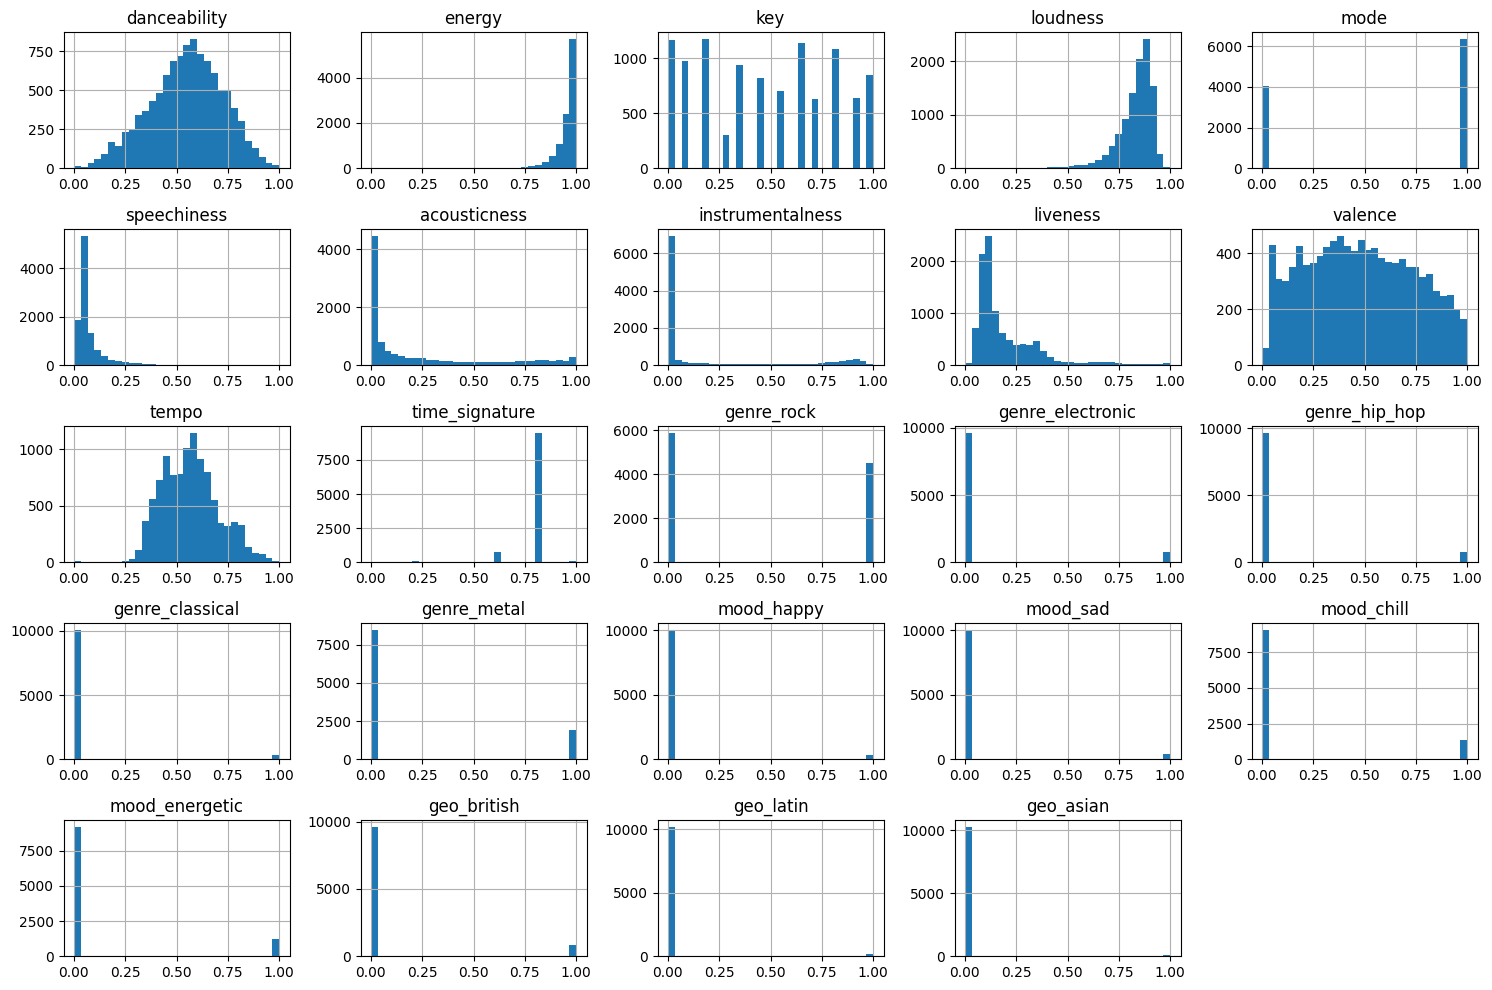

In [15]:
import matplotlib.pyplot as plt

spotify_new.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Features after Log Transformation + MinMax Scaling

# Interactions Matrix and Item Features Generation for LightFM

In [16]:
interactions_df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [17]:
interactions_df.merge(spotify_new.reset_index()[['artistID']], on = 'artistID', how = 'inner').shape[0] / interactions_df.shape[0]

0.8920977228170713

In [18]:
# remain just those kinds of artists who are matched wwith spotify dataset.
interactions_df = interactions_df.merge(spotify_new.reset_index()[['artistID']], on = 'artistID', how = 'inner')

In [19]:
interactions_df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [20]:
test_size = 0.15
val_size = 0.15
random_state = 42

In [21]:
# Split interactions into training, validation and test sets.

train_test_val_splitter = StandardLoader()

train_df, val_df, test_df = train_test_val_splitter.train_test_val_split(
            df=interactions_df,
            strategy="user_stratified",
            test_size=test_size,
            val_size=val_size,
            random_state=random_state,
        )

In [22]:
train_df.shape, val_df.shape, test_df.shape

((56237, 3), (13139, 3), (13441, 3))

In [23]:
# MinMax scaling for 'weight' (number of listenings)
minmax_scaler = UserMinMaxListeningScaler()

In [24]:
# fit_transform on the training dataset
train_df = minmax_scaler.fit_transform(train_df)

# Just transform on the validation and test datasets to prevent data leakage
val_df = minmax_scaler.transform(val_df)
test_df = minmax_scaler.transform(test_df)

<Axes: >

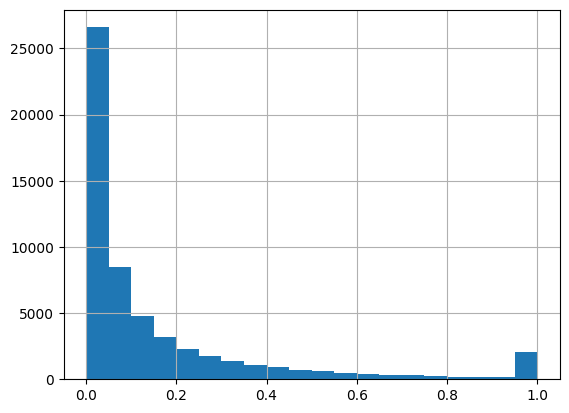

In [25]:
train_df['weight'].hist(bins=20)

In [26]:
# 1. FIT on ALL splits (train + val + test) to create mappings
interaction_builder = InteractionMatrixBuilder()
interaction_builder.fit(train_df, test_df, val_df)  # Creates consistent user/artist mappings

# 2. TRANSFORM each split separately
train_matrix = interaction_builder.transform(train_df)
val_matrix = interaction_builder.transform(val_df)
test_matrix = interaction_builder.transform(test_df)

In [27]:

# Now build artist features using the same artist_id_map
artists_lightfm_feature_builder = ArtistFeaturesBuilder()
artists_features = artists_lightfm_feature_builder.fit_transform(
    spotify_new, 
    interaction_builder.artist_id_map  # Pass the mapping here
)

# Baseline LightFM

In [ ]:
"""
Example usage of baseline model and optimizer
"""
# Define metrics to evaluate (REMOVE LightFMAUC and LightFMWARPLoss)
metrics = [
    PrecisionAtK(k=10),
    RecallAtK(k=10),
    MAPAtK(k=10),
    NDCGAtK(k=10)
]

print("STEP 1: Training Baseline Model")
print("-" * 70)

# Train baseline model
baseline = LightFMBaselineModel(
    no_components=64,
    loss='warp',
    learning_rate=0.05,
    epochs=30
)

baseline.fit(train_matrix, item_features=artists_features)

# Evaluate baseline
baseline_results = baseline.print_evaluation(
    train_matrix, val_matrix, test_matrix, 
    metrics=metrics, k=10
)

# Save baseline
baseline.save('models/baseline_model.pkl')

print("\n" + "=" * 70)
print("STEP 2: Hyperparameter Optimization")
print("=" * 70)

# Optimize hyperparameters (ADD matrix_builder and features_builder)
optimizer = LightFMOptunaOptimizer(
    train_matrix=train_matrix,
    val_matrix=val_matrix,
    item_features=artists_features,
    matrix_builder=interaction_builder, 
    features_builder=artists_lightfm_feature_builder, 
    optimization_metric='ndcg@10',
    direction='maximize',
    k=10
)

best_model = optimizer.optimize(
    metrics=metrics,
    n_trials=50,
    show_progress_bar=True
)

# Evaluate best model
print("\n" + "=" * 70)
print("BEST MODEL EVALUATION")
print("=" * 70)

best_results = best_model.print_evaluation(
    train_matrix, val_matrix, test_matrix,
    metrics=metrics, k=10
)

# Save best model (ADD save_components=True and test_matrix)
optimizer.save_best_model(
    'models/best_model.pkl',
    save_components=True,
    test_matrix=test_matrix           
)

print("\n" + "=" * 70)
print("COMPARISON: Baseline vs Best Model")
print("=" * 70)
print(f"\n{'Metric':<20} {'Baseline':<12} {'Best':<12} {'Improvement':<12}")
print("-" * 70)

for metric_name in baseline_results['test'].keys():
    baseline_score = baseline_results['test'][metric_name]
    best_score = best_results['test'][metric_name]
    
    if baseline_score is not None and best_score is not None:
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        print(f"{metric_name:<20} {baseline_score:<12.6f} {best_score:<12.6f} {improvement:+.2f}%")

print("=" * 70)

STEP 1: Training Baseline Model
----------------------------------------------------------------------


Epoch: 100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


BASELINE MODEL EVALUATION

Model Configuration:
  Loss: warp
  Embedding dim: 64
  Learning rate: 0.05
  Epochs: 30

------------------------------TRAIN SET-------------------------------
  precision@10        : 0.046713
  recall@10           : 0.015046
  map@10              : 0.024856
  ndcg@10             : 0.059431

----------------------------VALIDATION SET----------------------------
  precision@10        : 0.009888
  recall@10           : 0.013068
  map@10              : 0.005239
  ndcg@10             : 0.013918

-------------------------------TEST SET-------------------------------


[I 2025-12-16 11:26:10,570] A new study created in memory with name: no-name-8c23d559-3974-4eed-9c7d-b14c28c8ad42


  precision@10        : 0.000957
  recall@10           : 0.002664
  map@10              : 0.000966
  ndcg@10             : 0.002025


STEP 2: Hyperparameter Optimization
STARTING HYPERPARAMETER OPTIMIZATION WITH OPTUNA
Optimization metric: ndcg@10
Direction: maximize
Number of trials: 50
K value: 10



Best trial: 0. Best value: 0.0168132:   2%|▏         | 1/50 [00:03<02:48,  3.43s/it]

[I 2025-12-16 11:26:14,005] Trial 0 finished with value: 0.01681322252929571 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.0020513382630874496, 'epochs': 15}. Best is trial 0 with value: 0.01681322252929571.


Best trial: 1. Best value: 0.017005:   4%|▍         | 2/50 [00:07<03:06,  3.89s/it] 

[I 2025-12-16 11:26:18,215] Trial 1 finished with value: 0.017005010491273405 and parameters: {'no_components': 16, 'loss': 'warp', 'learning_rate': 0.0010994335574766201, 'epochs': 50}. Best is trial 1 with value: 0.017005010491273405.


Best trial: 2. Best value: 0.0171876:   6%|▌         | 3/50 [00:17<05:10,  6.60s/it]

[I 2025-12-16 11:26:28,032] Trial 2 finished with value: 0.017187581967638067 and parameters: {'no_components': 112, 'loss': 'warp', 'learning_rate': 0.004059611610484304, 'epochs': 30}. Best is trial 2 with value: 0.017187581967638067.


Best trial: 2. Best value: 0.0171876:   8%|▊         | 4/50 [00:24<05:13,  6.83s/it]

[I 2025-12-16 11:26:35,207] Trial 3 finished with value: 0.014704704713671782 and parameters: {'no_components': 64, 'loss': 'bpr', 'learning_rate': 0.0038396292998041735, 'epochs': 25}. Best is trial 2 with value: 0.017187581967638067.


Best trial: 4. Best value: 0.0175036:  10%|█         | 5/50 [00:27<04:05,  5.45s/it]

[I 2025-12-16 11:26:38,223] Trial 4 finished with value: 0.017503565853189094 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.015304852121831466, 'epochs': 10}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  12%|█▏        | 6/50 [00:39<05:32,  7.56s/it]

[I 2025-12-16 11:26:49,885] Trial 5 finished with value: 0.014169239781329371 and parameters: {'no_components': 80, 'loss': 'warp-kos', 'learning_rate': 0.08536189862866832, 'epochs': 45}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  14%|█▍        | 7/50 [00:45<05:11,  7.24s/it]

[I 2025-12-16 11:26:56,457] Trial 6 finished with value: 0.014428622406410692 and parameters: {'no_components': 48, 'loss': 'bpr', 'learning_rate': 0.0017541893487450805, 'epochs': 30}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  16%|█▌        | 8/50 [00:48<04:07,  5.90s/it]

[I 2025-12-16 11:26:59,504] Trial 7 finished with value: 0.01709439591057448 and parameters: {'no_components': 16, 'loss': 'warp', 'learning_rate': 0.004201672054372531, 'epochs': 30}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  18%|█▊        | 9/50 [01:04<06:02,  8.84s/it]

[I 2025-12-16 11:27:14,810] Trial 8 finished with value: 0.007855955424549466 and parameters: {'no_components': 80, 'loss': 'bpr', 'learning_rate': 0.0756829206016762, 'epochs': 50}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  20%|██        | 10/50 [01:10<05:16,  7.91s/it]

[I 2025-12-16 11:27:20,643] Trial 9 finished with value: 0.017104043597208275 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.0012315571723666018, 'epochs': 20}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  22%|██▏       | 11/50 [01:15<04:36,  7.10s/it]

[I 2025-12-16 11:27:25,881] Trial 10 finished with value: 0.01652344226620372 and parameters: {'no_components': 128, 'loss': 'warp-kos', 'learning_rate': 0.024673775376624445, 'epochs': 10}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  24%|██▍       | 12/50 [01:29<05:46,  9.12s/it]

[I 2025-12-16 11:27:39,634] Trial 11 finished with value: 0.016138370474942664 and parameters: {'no_components': 128, 'loss': 'warp', 'learning_rate': 0.013525587002907881, 'epochs': 40}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  26%|██▌       | 13/50 [01:33<04:40,  7.58s/it]

[I 2025-12-16 11:27:43,682] Trial 12 finished with value: 0.017322761846691775 and parameters: {'no_components': 112, 'loss': 'warp', 'learning_rate': 0.012153000200614474, 'epochs': 10}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  28%|██▊       | 14/50 [01:36<03:49,  6.37s/it]

[I 2025-12-16 11:27:47,263] Trial 13 finished with value: 0.01637184808970099 and parameters: {'no_components': 96, 'loss': 'warp', 'learning_rate': 0.025336508150556224, 'epochs': 10}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  30%|███       | 15/50 [01:43<03:49,  6.57s/it]

[I 2025-12-16 11:27:54,272] Trial 14 finished with value: 0.01698082851999487 and parameters: {'no_components': 112, 'loss': 'warp', 'learning_rate': 0.010307116449930287, 'epochs': 20}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  32%|███▏      | 16/50 [01:47<03:19,  5.87s/it]

[I 2025-12-16 11:27:58,511] Trial 15 finished with value: 0.01693413827481841 and parameters: {'no_components': 48, 'loss': 'warp-kos', 'learning_rate': 0.02170948926191492, 'epochs': 15}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  34%|███▍      | 17/50 [01:51<02:52,  5.22s/it]

[I 2025-12-16 11:28:02,242] Trial 16 finished with value: 0.01611455500169281 and parameters: {'no_components': 96, 'loss': 'warp', 'learning_rate': 0.038484355678745745, 'epochs': 10}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  36%|███▌      | 18/50 [01:56<02:44,  5.15s/it]

[I 2025-12-16 11:28:07,218] Trial 17 finished with value: 0.01749792246401465 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.00654210731515927, 'epochs': 20}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  38%|███▊      | 19/50 [02:01<02:34,  4.97s/it]

[I 2025-12-16 11:28:11,763] Trial 18 finished with value: 0.016776131758212253 and parameters: {'no_components': 32, 'loss': 'warp-kos', 'learning_rate': 0.006337411963587619, 'epochs': 20}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  40%|████      | 20/50 [02:08<02:52,  5.74s/it]

[I 2025-12-16 11:28:19,302] Trial 19 finished with value: 0.014312257418798845 and parameters: {'no_components': 64, 'loss': 'bpr', 'learning_rate': 0.006036353518858996, 'epochs': 25}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 4. Best value: 0.0175036:  42%|████▏     | 21/50 [02:11<02:21,  4.88s/it]

[I 2025-12-16 11:28:22,191] Trial 20 finished with value: 0.016504373772879898 and parameters: {'no_components': 32, 'loss': 'warp', 'learning_rate': 0.04161353894504908, 'epochs': 15}. Best is trial 4 with value: 0.017503565853189094.


Best trial: 21. Best value: 0.0175088:  44%|████▍     | 22/50 [02:14<02:02,  4.36s/it]

[I 2025-12-16 11:28:25,320] Trial 21 finished with value: 0.017508804458150198 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.014425540650734167, 'epochs': 10}. Best is trial 21 with value: 0.017508804458150198.


Best trial: 21. Best value: 0.0175088:  46%|████▌     | 23/50 [02:18<01:55,  4.28s/it]

[I 2025-12-16 11:28:29,420] Trial 22 finished with value: 0.017433325774745986 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.016447226899950346, 'epochs': 15}. Best is trial 21 with value: 0.017508804458150198.


Best trial: 21. Best value: 0.0175088:  48%|████▊     | 24/50 [02:24<02:03,  4.75s/it]

[I 2025-12-16 11:28:35,263] Trial 23 finished with value: 0.017417883365603213 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.008134259750276802, 'epochs': 25}. Best is trial 21 with value: 0.017508804458150198.


Best trial: 24. Best value: 0.0176095:  50%|█████     | 25/50 [02:30<02:08,  5.15s/it]

[I 2025-12-16 11:28:41,336] Trial 24 finished with value: 0.017609462141503215 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.007483847017415444, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  52%|█████▏    | 26/50 [02:35<02:04,  5.17s/it]

[I 2025-12-16 11:28:46,551] Trial 25 finished with value: 0.01710044141474482 and parameters: {'no_components': 32, 'loss': 'warp', 'learning_rate': 0.017389929268689642, 'epochs': 40}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  54%|█████▍    | 27/50 [02:42<02:04,  5.43s/it]

[I 2025-12-16 11:28:52,584] Trial 26 finished with value: 0.014224341460173035 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.03657309228647366, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  56%|█████▌    | 28/50 [02:48<02:04,  5.65s/it]

[I 2025-12-16 11:28:58,745] Trial 27 finished with value: 0.017315183392267668 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.009341993553965335, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  58%|█████▊    | 29/50 [03:01<02:47,  7.99s/it]

[I 2025-12-16 11:29:12,209] Trial 28 finished with value: 0.016816414305579928 and parameters: {'no_components': 96, 'loss': 'warp-kos', 'learning_rate': 0.002988092072471753, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  60%|██████    | 30/50 [03:08<02:30,  7.54s/it]

[I 2025-12-16 11:29:18,698] Trial 29 finished with value: 0.014770134026509056 and parameters: {'no_components': 32, 'loss': 'bpr', 'learning_rate': 0.0025022567394143214, 'epochs': 40}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  62%|██████▏   | 31/50 [03:12<02:05,  6.61s/it]

[I 2025-12-16 11:29:23,128] Trial 30 finished with value: 0.014806296018684271 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.06260320009195326, 'epochs': 15}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  64%|██████▍   | 32/50 [03:17<01:49,  6.11s/it]

[I 2025-12-16 11:29:28,067] Trial 31 finished with value: 0.01757695508420857 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.006748036549074832, 'epochs': 20}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  66%|██████▌   | 33/50 [03:20<01:28,  5.22s/it]

[I 2025-12-16 11:29:31,208] Trial 32 finished with value: 0.017205332190110605 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.007731789801741323, 'epochs': 10}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  68%|██████▊   | 34/50 [03:24<01:15,  4.70s/it]

[I 2025-12-16 11:29:34,709] Trial 33 finished with value: 0.01750378984291947 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.013251979689832133, 'epochs': 15}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  70%|███████   | 35/50 [03:29<01:12,  4.82s/it]

[I 2025-12-16 11:29:39,808] Trial 34 finished with value: 0.01699585366325088 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.00494364990408322, 'epochs': 25}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  72%|███████▏  | 36/50 [03:31<00:57,  4.09s/it]

[I 2025-12-16 11:29:42,185] Trial 35 finished with value: 0.017180399272212838 and parameters: {'no_components': 16, 'loss': 'warp', 'learning_rate': 0.012227675679958987, 'epochs': 15}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  74%|███████▍  | 37/50 [03:35<00:50,  3.88s/it]

[I 2025-12-16 11:29:45,585] Trial 36 finished with value: 0.017228496544908083 and parameters: {'no_components': 32, 'loss': 'warp', 'learning_rate': 0.019171965641224926, 'epochs': 20}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  76%|███████▌  | 38/50 [03:40<00:52,  4.37s/it]

[I 2025-12-16 11:29:51,107] Trial 37 finished with value: 0.016999236413526627 and parameters: {'no_components': 48, 'loss': 'warp', 'learning_rate': 0.004825034947064842, 'epochs': 30}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  78%|███████▊  | 39/50 [03:44<00:47,  4.29s/it]

[I 2025-12-16 11:29:55,207] Trial 38 finished with value: 0.01460805351121969 and parameters: {'no_components': 48, 'loss': 'bpr', 'learning_rate': 0.003232378564167252, 'epochs': 15}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  80%|████████  | 40/50 [03:50<00:48,  4.81s/it]

[I 2025-12-16 11:30:01,231] Trial 39 finished with value: 0.01754323848485805 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.010791216380624361, 'epochs': 25}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  82%|████████▏ | 41/50 [03:57<00:48,  5.42s/it]

[I 2025-12-16 11:30:08,084] Trial 40 finished with value: 0.017092687271047968 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.009668228045708452, 'epochs': 25}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  84%|████████▍ | 42/50 [04:02<00:41,  5.22s/it]

[I 2025-12-16 11:30:12,829] Trial 41 finished with value: 0.017465687835291996 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.011479563330185658, 'epochs': 20}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  86%|████████▌ | 43/50 [04:09<00:41,  5.87s/it]

[I 2025-12-16 11:30:20,213] Trial 42 finished with value: 0.01759632489749186 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.007859152596166208, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  88%|████████▊ | 44/50 [04:17<00:38,  6.43s/it]

[I 2025-12-16 11:30:27,960] Trial 43 finished with value: 0.017422160575469227 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.007182945227692085, 'epochs': 30}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  90%|█████████ | 45/50 [04:24<00:33,  6.75s/it]

[I 2025-12-16 11:30:35,439] Trial 44 finished with value: 0.017398947019906578 and parameters: {'no_components': 64, 'loss': 'warp', 'learning_rate': 0.005223822528880653, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  92%|█████████▏| 46/50 [04:37<00:33,  8.47s/it]

[I 2025-12-16 11:30:47,935] Trial 45 finished with value: 0.017142334259232575 and parameters: {'no_components': 64, 'loss': 'warp-kos', 'learning_rate': 0.003673056383455245, 'epochs': 45}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  94%|█████████▍| 47/50 [04:44<00:24,  8.15s/it]

[I 2025-12-16 11:30:55,322] Trial 46 finished with value: 0.017543045140696822 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.008651335712920889, 'epochs': 30}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  96%|█████████▌| 48/50 [04:54<00:17,  8.59s/it]

[I 2025-12-16 11:31:04,948] Trial 47 finished with value: 0.012970098997144281 and parameters: {'no_components': 80, 'loss': 'bpr', 'learning_rate': 0.00820499549550649, 'epochs': 30}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095:  98%|█████████▊| 49/50 [05:02<00:08,  8.56s/it]

[I 2025-12-16 11:31:13,452] Trial 48 finished with value: 0.016919020865708293 and parameters: {'no_components': 96, 'loss': 'warp', 'learning_rate': 0.004272746101495666, 'epochs': 30}. Best is trial 24 with value: 0.017609462141503215.


Best trial: 24. Best value: 0.0176095: 100%|██████████| 50/50 [05:11<00:00,  6.24s/it]


[I 2025-12-16 11:31:22,375] Trial 49 finished with value: 0.016786844986734415 and parameters: {'no_components': 80, 'loss': 'warp', 'learning_rate': 0.00213625162824129, 'epochs': 35}. Best is trial 24 with value: 0.017609462141503215.

OPTIMIZATION COMPLETE

Best ndcg@10: 0.017609

Best hyperparameters:
  no_components       : 48
  loss                : warp
  learning_rate       : 0.007483847017415444
  epochs              : 35

----------------------------------------------------------------------
Training final model with best hyperparameters...
----------------------------------------------------------------------


Epoch: 100%|██████████| 35/35 [00:04<00:00,  7.34it/s]



Final model trained successfully!


BEST MODEL EVALUATION
BASELINE MODEL EVALUATION

Model Configuration:
  Loss: warp
  Embedding dim: 48
  Learning rate: 0.007483847017415444
  Epochs: 35

------------------------------TRAIN SET-------------------------------
  precision@10        : 0.043372
  recall@10           : 0.013949
  map@10              : 0.023997
  ndcg@10             : 0.057313

----------------------------VALIDATION SET----------------------------
  precision@10        : 0.010154
  recall@10           : 0.013443
  map@10              : 0.007604
  ndcg@10             : 0.017609

-------------------------------TEST SET-------------------------------
  precision@10        : 0.001063
  recall@10           : 0.002816
  map@10              : 0.000922
  ndcg@10             : 0.002005

Best model saved to: models/best_model.pkl
Optimization results saved to: models/optimization_results.pkl

SAVING PIPELINE COMPONENTS
✓ Interaction matrices saved to: models/interaction_matrices.p

After this process both the baseline and the tuned models are saved in the current directory.

For running inference it is crucial to save interaction matrix and item feature mappings as well.